In [83]:
import numpy as np
from tqdm import tqdm
import scipy.linalg as la
import scipy
import copy
J = 1 
hx, hz = -1.05, 0.5
L = 12
I = np.array([[1, 0], [0, 1]])
sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
omega_j = np.array([[-hz, -hx],
                    [-hx, hz]])


In [46]:
def exp_gate_real(hamiltonian, dt):
    from scipy.linalg import expm
    l = expm(-1j * dt * hamiltonian)
    return l

In [47]:

dt=0.01

def Hamiltonian(L, J, hx, hz, dt):
    gates_odd = []
    gates_even = []
    gates_field = []

    h_odd = np.zeros((2**L, 2**L), dtype=complex)
    h_even = np.zeros((2**L, 2**L), dtype=complex)
    h_field = np.zeros((2**L, 2**L), dtype=complex)

    print("Processing odd interactions...")
    for j in tqdm(range(1, L-1, 2)):
        term = -J * np.kron(np.kron(np.eye(2**(j-1)), np.kron(sigma_z, sigma_z)), np.eye(2**(L-j-1)))
        h_odd += term
        gates_odd.append(exp_gate_real(term, dt))

    print("Processing even interactions...")
    for j in tqdm(range(0, L, 2)):
        term = -J * np.kron(np.kron(np.eye(2**j), np.kron(sigma_z, sigma_z)), np.eye(2**(L-j-2)))
        h_even += term
        gates_even.append(exp_gate_real(term, dt))

    print("Processing field terms...")
    for j in tqdm(range(L)):
        term_x = -hx * np.kron(np.kron(np.eye(2**j), sigma_x), np.eye(2**(L-j-1)))
        term_z = -hz * np.kron(np.kron(np.eye(2**j), sigma_z), np.eye(2**(L-j-1)))
        term = term_x + term_z
        h_field += term
        gates_field.append(exp_gate_real(term, dt))

    H = h_odd + h_even + h_field
    return H, gates_odd, gates_even, gates_field
H, gates_odd, gates_even, gates_field = Hamiltonian(L, J, hx, hz, dt)

Processing odd interactions...


100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


Processing even interactions...


100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


Processing field terms...


  0%|          | 0/12 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [48]:
eigenvalues, eigenvectors = la.eigh(H, subset_by_index=[0,8])
ground_state_energy=min(eigenvalues)

NameError: name 'H' is not defined

In [ ]:
min_index = np.argmin(eigenvalues)
ground_state_wavefunction = eigenvectors[:, min_index]
print(ground_state_energy,ground_state_wavefunction)

In [60]:
import numpy as np


def apply_gate_to_bond(psi_left, psi_right, gate):
    dim_psi_left, dim_psi_right = psi_left.shape[0], psi_right.shape[2]
    psi2 = np.tensordot(psi_left, psi_right, axes=([2], [0]))
    expected_elements = dim_psi_left * 2 * dim_psi_right * 2
    actual_elements = psi2.size
    psi2 = psi2.reshape(dim_psi_left * 2, dim_psi_right * 2)
    gate = gate.reshape((2, 2, 2, 2))
    psi2 = np.tensordot(gate, psi2, axes=([2, 3], [0, 1]))
    psi2 = psi2.reshape(dim_psi_left, 2, 2, dim_psi_right).transpose(0, 2, 1, 3).reshape(dim_psi_left*2, dim_psi_right*2)
    U, S, Vh = np.linalg.svd(psi2, full_matrices=False)
    chi = min(len(S), max_bond_dim, dim_psi_right)
    U = U[:, :chi]
    S = np.diag(S[:chi])
    Vh = Vh[:chi, :]
    psi_left = U.reshape(-1, 2, chi)
    psi_right = (S @ Vh).reshape(chi, 2, -1)
    return psi_left, psi_right

def single_tebd_step(mps, gates_odd, gates_even, gates_field, dt):
    L = len(mps)
    evolved_mps = [np.copy(k) for k in mps]
    for i in range(L):
        evolved_mps[i] = np.tensordot(gates_field[i], evolved_mps[i], axes=([1], [1])).reshape(evolved_mps[i].shape)

    for i in range(1, L-1 , 2):
        evolved_mps[i], evolved_mps[i + 1] = apply_gate_to_bond(evolved_mps[i], evolved_mps[i + 1], gates_odd[i // 2])

    for i in range(0, L , 2):
        evolved_mps[i], evolved_mps[i + 1] = apply_gate_to_bond(evolved_mps[i], evolved_mps[i + 1], gates_even[i // 2])

    return mps
mps=ferromagnetic_state_MPS(L)
L = 12  
max_bond_dim = 30 
dt = 0.01  

step_number = 100  

for step in range(step_number):
    mps = single_tebd_step(mps, gates_odd, gates_even, gates_field, dt)

NameError: name 'gates_odd' is not defined

In [ ]:
def contract_mps_tensors(mps_tensors):
    state = mps_tensors[0]
    for i, tensor in enumerate(mps_tensors[1:], 1):
        if i == len(mps_tensors) - 1:
            state = np.einsum('...j,jk->...k', state, tensor)
        else:
            state = np.einsum('...j,jkl->...kl', state, tensor)

    return state.flatten()

In [57]:
def inner_product(bra, ket):
    result = np.einsum('jkl,mkn->ln', bra[0].conj(), ket[0])
    
    for i in range(1, len(ket)):

        A = np.einsum('jkl,mkn->jmln', bra[i].conj(), ket[i])
        result = np.einsum('jm,jmln->ln', result, A)
    
    return result.reshape(-1)[0]

In [58]:
def generate_denseH(L, J, hx, hz, periodic):
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])
    I = np.eye(2)
    H = np.zeros((2**L, 2**L))
    for i in range(L):
        H -= hx * np.kron(np.eye(2**i), np.kron(X, np.eye(2**(L-i-1))))
        H -= hz * np.kron(np.eye(2**i), np.kron(Z, np.eye(2**(L-i-1))))
        if i < L - 1:
            H -= J * np.kron(np.eye(2**i), np.kron(np.kron(Z, Z), np.eye(2**(L-i-2))))
        if periodic and i == L - 1:
            H -= J * np.kron(Z, np.kron(np.eye(2**(L-2)), Z))
    return H


In [59]:
def magnetic_term_canonical(canonical_tracker, hx, hz):
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])
    L = len(canonical_tracker) + 1
    results = np.zeros(L, dtype=complex)
    for i in range(L-1):
        U = canonical_tracker[i][0]
        S = canonical_tracker[i][1]
        Ssq = np.square(S)
        ZU = np.einsum('ij,kjm->kim', Z, U)
        XU = np.einsum('ij,kjm->kim', X, U)
        ZUS = np.einsum('kim,m->kim', ZU, Ssq)
        XUS = np.einsum('kim,m->kim', XU, Ssq)
        UhZUS = np.einsum('aib,kin->akbn', U.conj(), ZUS)
        UhXUS = np.einsum('aib,kin->akbn', U.conj(), XUS)

        results[i] = -hz * np.einsum('aabb', UhZUS) - hx * np.einsum('aabb', UhXUS)

    U, S = canonical_tracker[-1][:2]
    Ssq = np.square(S)
    if len(canonical_tracker[-1]) > 2 and canonical_tracker[-1][2] is not None:
        Vh = canonical_tracker[-1][2]
        ZVh = np.einsum('ij,kjm->kim', Z, Vh)
        XVh = np.einsum('ij,kjm->kim', X, Vh)
        
        ZVhS = np.einsum('jk,kim->jim', Ssq, ZVh)
        XVhS = np.einsum('jk,kim->jim', Ssq, XVh)
        VZVhS = np.einsum('aib,kin->akbn', Vh.conj(), ZVhS)
        VXVhS = np.einsum('aib,kin->akbn', Vh.cone)

        results[L-1] = -hz * np.einsum('aabb', VZVhS) - hx * np.einsum('aabb', VXVhS)
    else:
        results[L-1] = 0

    return np.sum(results)

In [ ]:
def contract_mps_tensors(mps_tensors):
    state = mps_tensors[0]
    for tensor in mps_tensors[1:]:
        state = np.einsum('...ijk,klm->...ilm', state, tensor)
    return state.flatten()

4.1

In [50]:
def ferromagnetic_state_MPS(L):
    mps_tensors= []
    A = np.zeros((1, 2, 1), dtype = complex)
    A[0, 0, 0] = 1
    A[0, 1, 0] = 0
    for i in range(L):
        mps_tensors.append(A)
    return mps_tensors

In [61]:
import numpy as np
def Hamiltonian_gates(L, J, hx, hz, dt):
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
    sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    gates_odd = []
    gates_even = []
    for j in range(1, L, 2):
        term = -J * np.kron(sigma_z, sigma_z)
        gates_odd.append(term)

    for j in range(0, L-1, 2):
        term = -J * np.kron(sigma_z, sigma_z)
        gates_even.append(term)

    return gates_odd, gates_even

def exp_gate(hamiltonian, dt, imaginary_time):
    from scipy.linalg import expm
    if imaginary_time:
        matrix = expm(-dt * hamiltonian)
    else:
        matrix = expm(-1j * dt * hamiltonian)
    return matrix.reshape(2, 2, 2, 2)

def apply_gate_to_bond(psi_left, psi_right, gate):
    if psi_right.shape[2] == 1:
        psi_left = psi_left.reshape(-1, 2, 1)
        psi_right = psi_right.reshape(1, 2, -1)
        return psi_left, psi_right
    combined_psi = np.tensordot(psi_left, psi_right, axes=([2], [0]))
    combined_psi = np.tensordot(gate, combined_psi, axes=[[2, 3], [1, 2]])
    combined_psi = combined_psi.transpose(0, 2, 1, 3).reshape((4, 1))
    U, S, Vh = np.linalg.svd(combined_psi, full_matrices=False)
    chi = min(len(S), max_bond_dim)
    U = U[:, :chi]
    S = np.diag(S[:chi])
    Vh = Vh[:chi, :]

    print("U shape:", U.shape, "S shape:", S.shape, "Vh shape:", Vh.shape)
    psi_left = U.reshape(-1, 2, chi)
    psi_right = (S @ Vh).reshape(chi, 2, -1)


    return psi_left, psi_right


def single_tebd_step(mps, gates_odd, gates_even):
    for i in range(1, len(mps) - 1, 2):
        mps[i], mps[i + 1] = apply_gate_to_bond(mps[i], mps[i + 1], gates_odd[i // 2])
    for i in range(0, len(mps) - 1, 2):
        mps[i], mps[i + 1] = apply_gate_to_bond(mps[i], mps[i + 1], gates_even[i // 2])
    return mps

def imaginary_time_tebd(L, J, hx, hz, dt, step_number, max_bond_dim):
    gates_odd, gates_even = Hamiltonian_gates(L, J, hx, hz, dt)
    gates_odd = [exp_gate(gate, dt, imaginary_time=True) for gate in gates_odd]
    gates_even = [exp_gate(gate, dt, imaginary_time=True) for gate in gates_even]
    mps = ferromagnetic_state_MPS(L)
    for _ in range(step_number):
        mps = single_tebd_step(mps, gates_odd, gates_even)

    return mps

L = 12
dt = 0.01
max_bond_dim = 30

mps_ground_state = imaginary_time_tebd(L, J, hx, hz, dt, step_number, max_bond_dim)


In [62]:
def magnetic_term(ket, hx, hz):
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])
    L = len(ket)
    results = np.zeros(L, dtype = complex)
    for i in range(L):
        
        Hket = [np.copy(k) for k in ket]
    
        Hket[i] = hx*np.einsum('ij,kjm->kim', X, ket[i]) + hz*np.einsum('ij,kjm->kim', Z, ket[i])
        
        results[i] = inner_product(ket, Hket)
        
    return np.sum(results)
        

def ising_term(ket):
    
    Z = np.array([[1,0],[0,-1]])
    L = len(ket)
    results = np.zeros(L, dtype = complex)
    
    for i in range(0, L-1):
        
        Hket = [np.copy(k) for k in ket]
        
        Hket[i] = np.einsum('ij,kjm->kim', Z, ket[i])
        
        Hket[i+1] = np.einsum('ij,kjm->kim', Z, ket[i+1])
        
        results[i] = inner_product(ket, Hket)
        
    return np.sum(results)

def expectation_value_energy(ket, hx, hz, J):
    
    energy = -magnetic_term(ket, hx, hz)-J*ising_term(ket)
    norm = inner_product(ket, ket)
    
    return energy/norm



In [63]:
def initialize_state(L):
    
    
    mps_tensors= []
    
    A = np.zeros((1, 2, 1), dtype = complex)
    A[0, 0, 0] = 1
    A[0, 1, 0] = 0
    
    for i in range(L):
        mps_tensors.append(A)

    return mps_tensors

In [65]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from tqdm import tqdm
L = 12
J = 1.0
hx, hz = -1.05, 0.5
chi = 16
periodic=False
epsilon = 1e-5
def single_step_tebd(tensor, gates_odd, gates_even, gates_field):
    L = len(tensor)
    for i in range(L):
        tensor[i] = np.tensordot(gates_field[i], tensor[i], axes=([1], [1]))
    for i in range(1, L-1, 2):
        tensor[i], tensor[i + 1] = apply_gate_to_tensor(tensor[i], tensor[i + 1], gates_odd[i // 2])
    for i in range(0, L-1, 2):
        tensor[i], tensor[i + 1] = apply_gate_to_tensor(tensor[i], tensor[i + 1], gates_even[i // 2])
    return tensor
def apply_gate_to_tensor(psi_left, psi_right, gate):
    combined_psi = np.tensordot(psi_left, psi_right, axes=([2], [0]))
    combined_psi = np.tensordot(gate, combined_psi, axes=[[2, 3], [1, 2]])
    combined_psi = combined_psi.transpose(0, 2, 1, 3).reshape((4, 1))
    U, S, Vh = np.linalg.svd(combined_psi, full_matrices=False)
    chi = min(len(S), 16)
    U = U[:, :chi]
    S = np.diag(S[:chi])
    Vh = Vh[:chi, :]
    psi_left = U.reshape(-1, 2, chi)
    psi_right = (S @ Vh).reshape(chi, 2, -1)
    return psi_left, psi_right
def imaginary_tebd(L, J, hx, hz, dt, step_number, max_bond_dim):
    gates_odd, gates_even = create_H_gates(L, J, hx, hz, dt)
    gates_odd = [exponential_gate(gate, dt, imaginary_time=True) for gate in gates_odd]
    gates_even = [exponential_gate(gate, dt, imaginary_time=True) for gate in gates_even]
    gates_field = [exponential_gate(np.array([[-hz, -hx], [-hx, hz]]), dt, imaginary_time=True) for _ in range(L)]
    tensor = initialize_tensor(L)
    for _ in range(step_number):
        tensor = single_step_tebd(tensor, gates_odd, gates_even, gates_field)
    return tensor
def exponential_gate(hamiltonian, dt, imaginary_time):
    from scipy.linalg import expm
    if imaginary_time:
        matrix = expm(-dt * hamiltonian)
    else:
        matrix = expm(-1j * dt * hamiltonian)
    return matrix.reshape(2, 2, 2, 2)
def conserve_bond_dim(k, canonical_mps):
    truncated_mps = canonical_mps.copy()
    L = len(canonical_mps)
    canonical_tracker = []
    for i in range(L-1, 0, -1):
        W = np.einsum('ijk,klm->ijlm', truncated_mps[i-1], truncated_mps[i])
        Wmatrix = W.reshape((W.shape[0]*2, -1))
        U, S, Vh = np.linalg.svd(Wmatrix, full_matrices=False)
        chi = min(k, len(S))
        U = U[:, :chi]
        Vh = Vh[:chi, :]
        truncated_mps[i] = Vh.reshape(chi, 2, -1)
        truncated_mps[i-1] = (U @ np.diag(S[:chi])).reshape(-1, 2, chi)
    canonical_tensors = truncated_mps.copy()
    for i in range(L-1):
        W = np.einsum('ijk,klm->ijlm', canonical_tensors[i], canonical_tensors[i+1])
        Wmatrix = W.reshape((W.shape[0]*2, -1))
        U, S, Vh = np.linalg.svd(Wmatrix, full_matrices=False)
        chi = min(k, len(S))
        U = U[:, :chi]
        Vh = Vh[:chi, :]
        canonical_tracker.append([U.reshape(-1, 2, chi), S[:chi], Vh.reshape(chi, 2, -1)])
        canonical_tensors[i+1] = (np.diag(S[:chi]) @ Vh).reshape(chi, 2, -1)
    return truncated_mps, canonical_tracker
def create_H_gates(L, J, hx, hz, dt):
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
    sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    gates_odd = []
    gates_even = []
    for j in range(1, L, 2):
        term = -J * np.kron(sigma_z, sigma_z)
        gates_odd.append(term)
    for j in range(0, L-1, 2):
        term = -J * np.kron(sigma_z, sigma_z)
        gates_even.append(term)
    return gates_odd, gates_even
def find_ground_state(dt, J, hx, hz, ket, k, epsilon=0.0001, max_iterations=1000):
    ket_initial, canonical_tracker = conserve_bond_dim(k, ket)
    energy = calc_exp_value_canonical(canonical_tracker, hx, hz, J)
    energies = [energy]
    canonical_trackers = [canonical_tracker]
    evolved_ket = ket.copy()
    with tqdm(total=max_iterations, desc="Iterations", unit="step") as pbar:
        for iteration in range(max_iterations):
            evolved_ket, canonical_tracker = step(dt, J, hx, hz, evolved_ket, k)
            energy = calc_exp_value_canonical(canonical_tracker, hx, hz, J)
            energies.append(energy)
            canonical_trackers.append(canonical_tracker)
            pbar.update(1)
            if np.abs((energies[-1]-energies[-2]) / energies[-1]) < epsilon:
                break
    return energies[-1], evolved_ket, energies, canonical_trackers
def step(dt, J, hx, hz, ket, k):
    evolved_ket = canonical_conversion(
        twosite_odd_step(
            dt, J,
            twosite_even_step(
                dt, J,
                local_step(dt, hx, hz, ket.copy())
            )
        )
    )
    return conserve_bond_dim(k, evolved_ket)
def local_step(dt, hx, hz, ket):
    L = len(ket)
    w = np.array([[-hz, -hx], [-hx, hz]])
    R = la.expm(-dt * w)
    ket_new = []
    for i in range(L):
        ket_new.append(np.einsum('ij,kjm->kim', R, ket[i]))
    return ket_new
def canonical_conversion(tensors):
    new_tensors = tensors.copy()
    L = len(new_tensors)
    for i in range(L-1):
        W = np.einsum('ijk,klm->ijlm', new_tensors[i], new_tensors[i+1])
        Wmatrix = W.reshape((W.shape[0]*2, -1))
        U, S, Vh = np.linalg.svd(Wmatrix, full_matrices=False)
        chi = len(S)
        U = U[:, :chi]
        new_tensors[i] = U.reshape(-1, 2, chi)
        S = np.diag(S[:chi])
        Vh = Vh[:chi, :]
        new_tensors[i+1] = (S @ Vh).reshape(chi, 2, -1)
    return new_tensors
def evolve_time(T, J, hx, hz, ket, k, iters):
    dt = T / iters
    ket_initial, canonical_tracker = conserve_bond_dim(k, ket)
    energy = calc_exp_value_canonical(canonical_tracker, hx, hz, J)
    energies = [energy]
    evolved_ket = ket.copy()
    for i in range(iters):
        evolved_ket, canonical_tracker = step(dt, J, hx, hz, evolved_ket, k)
        energy = calc_exp_value_canonical(canonical_tracker, hx, hz, J)
        energies.append(energy)
    return evolved_ket, energies, canonical_tracker
def ising_term(ket):
    Z = np.array([[1, 0], [0, -1]])
    L = len(ket)
    results = np.zeros(L, dtype=complex)
    for i in range(0, L-1):
        Hket = [np.copy(k) for k in ket]
        Hket[i] = np.einsum('ij,kjm->kim', Z, ket[i])
        Hket[i + 1] = np.einsum('ij,kjm->kim', Z, ket[i + 1])
        results[i] = inner_product(ket, Hket)
    return np.sum(results)
def twosite_even_step(dt, J, ket):
    L = len(ket)
    Z = np.array([[1, 0], [0, -1]])
    H = dt * J * np.kron(Z, Z)
    T = la.expm(H).reshape(2, 2, 2, 2)
    ket_new = []
    for i in range(0, L-1, 2):
        A = np.einsum('ijk,klm->ijlm', ket[i], ket[i + 1])
        W = np.einsum('abjl,ijlm->iabm', T, A)
        W = W.reshape(W.shape[0] * W.shape[1], -1)
        U, S, Vh = np.linalg.svd(W, full_matrices=False)
        chi = len(S)
        ket_new.append(U.reshape((-1, 2, chi)))
        ket_new.append((np.diag(S) @ Vh).reshape(chi, 2, -1))
    if L % 2 != 0:
        ket_new.append(ket[L-1])
    return ket_new
def twosite_odd_step(dt, J, ket):
    L = len(ket)
    Z = np.array([[1, 0], [0, -1]])
    H = dt * J * np.kron(Z, Z)
    T = la.expm(H).reshape(2, 2, 2, 2)
    ket_new = []
    ket_new.append(ket[0])
    for i in range(1, L-1, 2):
        A = np.einsum('ijk,klm->ijlm', ket[i], ket[i + 1])
        W = np.einsum('abjl,ijlm->iabm', T, A)
        W = W.reshape(W.shape[0] * W.shape[1], -1)
        U, S, Vh = np.linalg.svd(W, full_matrices=False)
        chi = len(S)
        ket_new.append(U.reshape((-1, 2, chi)))
        ket_new.append((np.diag(S) @ Vh).reshape(chi, 2, -1))
    if L % 2 == 0:
        ket_new.append(ket[L-1])
    return ket_new
def magnetic_term(ket, hx, hz):
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])
    L = len(ket)
    results = np.zeros(L, dtype=complex)
    for i in range(L):
        Hket = [np.copy(k) for k in ket]
        Hket[i] = hx * np.einsum('ij,kjm->kim', X, ket[i]) + hz * np.einsum('ij,kjm->kim', Z, ket[i])
        results[i] = inner_product(ket, Hket)
    return np.sum(results)
def magnetic_term_canonical(canonical_tracker, hx, hz):
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])
    L = len(canonical_tracker) + 1
    results = np.zeros(L, dtype=complex)
    for i in range(L-1):
        U = canonical_tracker[i][0]
        S = np.diag(canonical_tracker[i][1])
        Ssq = np.einsum('ij,kj->ik', S.conj(), S)
        ZU = np.einsum('ij,kjm->kim', Z, U)
        XU = np.einsum('ij,kjm->kim', X, U)
        ZUS = np.einsum('kim,nm->kin', ZU, Ssq)
        XUS = np.einsum('kim,nm->kin', XU, Ssq)
        UhZUS = np.einsum('aib,kin->akbn', U.conj(), ZUS)
        UhXUS = np.einsum('aib,kin->akbn', U.conj(), XUS)
        results[i] = -hz * np.einsum('aabb', UhZUS) - hx * np.einsum('aabb', UhXUS)
    Ssq = np.einsum('ij,ik->jk', S.conj(), S)
    Vh = canonical_tracker[L-2][2]
    ZVh = np.einsum('ij,kjm->kim', Z, Vh)
    XVh = np.einsum('ij,kjm->kim', X, Vh)
    ZVhS = np.einsum('jk,kim->jim', Ssq, ZVh)
    XVhS = np.einsum('jk,kim->jim', Ssq, XVh)
    VZVhS = np.einsum('aib,kin->akbn', Vh.conj(), ZVhS)
    VXVhS = np.einsum('aib,kin->akbn', Vh.conj(), XVhS)
    results[L-1] = -hz * np.einsum('aabb', VZVhS) - hx * np.einsum('aabb', VXVhS)
    return np.sum(results) / np.sum(Ssq)
def calc_exp_value(ket, hx, hz, J):
    energy = -magnetic_term(ket, hx, hz) - J * ising_term(ket)
    norm = inner_product(ket, ket)
    return energy / norm
def ising_term_canonical(canonical_tracker, J):
    Z = np.array([[1, 0], [0, -1]])
    L = len(canonical_tracker) + 1
    results = np.zeros(L, dtype=complex)
    for i in range(L-1):
        U = canonical_tracker[i][0]
        S = np.diag(canonical_tracker[i][1])
        Vh = canonical_tracker[i][2]
        Uh = U.conj()
        V = Vh.conj()
        US = np.einsum('abc,cd->abd', U, S)
        USVh = np.einsum('abd,def->abef', US, Vh)
        UhS = np.einsum('abc,cd->abd', Uh, S)
        UhSV = np.einsum('abd,def->abef', UhS, V)
        ZUSVh = np.einsum('ib,abef->aief', Z, USVh)
        ZUSVhZ = np.einsum('je,aief->aijf', Z, ZUSVh)
        UhSV_ZUSVhZ = np.einsum('abcd,ebcf->aedf', UhSV, ZUSVhZ)
        results[i] = -J * np.einsum('aabb', UhSV_ZUSVhZ)
    return np.sum(results) / np.sum(S**2)
def calc_exp_value_canonical(canonical_tracker, hx, hz, J):
    return magnetic_term_canonical(canonical_tracker, hx, hz) + ising_term_canonical(canonical_tracker, J)
L = 12
dt = 0.1
chi = 16
H = generate_denseH(L, J, hx, hz, periodic)
eigs, vecs = la.eigh(H)
true_energy = eigs[0]
ket = initialize_state(L)
ground_state_energy, evolved_ket, energies_01, canonical_tracker = find_ground_state(0.1, J, hx, hz, ket, chi, 1e-5, max_iterations=2000)
error_01 = (true_energy-ground_state_energy)/true_energy.real * 1000
print(f'Using delta t =0.01 we are off by {error_01} %')
ground_state_energy, evolved_ket, energies_001, canonical_tracker = find_ground_state(0.01, J, hx, hz, ket, chi, 1e-6, max_iterations=2000)
error_001 = (true_energy-ground_state_energy)/true_energy.real * 1000
print(f'Using delta t =0.001 we are off by {error_001}%')
ground_state_energy, evolved_ket, energies_0001, canonical_tracker = find_ground_state(0.001, J, hx, hz, ket, chi, 1e-7, max_iterations=2000)
error_0001 = (true_energy-ground_state_energy)/true_energy.real * 1000
print(f'Using delta t =0.0001 we are off by {error_0001}%')

Iterations:   1%|          | 21/2000 [00:00<01:20, 24.72step/s]


Using delta t =0.01 we are off by (4.119161661098424+0j) %


Iterations:   7%|▋         | 149/2000 [00:07<01:35, 19.42step/s]


Using delta t =0.001 we are off by (0.06563372793165924+0j)%


Iterations:  69%|██████▉   | 1376/2000 [00:50<00:22, 27.50step/s]

Using delta t =0.0001 we are off by (0.01819767964976995+0j)%


In [ ]:
plt.figure(figsize=(10, 6))
colors = ['xkcd:blue', 'xkcd:bright red', 'xkcd:orange']
plt.plot(energies_01, label='$\delta\\tau=0.1$ \epsilon=10^{-5}', color=colors[0], linewidth=2)
plt.plot(energies_001, label='$\delta\\tau=0.01$' '\epsilon=10^{-6}', color=colors[1], markersize=4, linewidth=2)
plt.plot(energies_0001, label='$\delta\\tau=0.001$'  '\epsilon=10^{-7}', color=colors[2], markersize=4, linewidth=2)
plt.axhline(true_energy, label='Actual E_0', linestyle='dashdot', color='green', linewidth=2)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Ground State Energy', fontsize=14)
plt.title('Convergence of Ground State Energy for L=12', fontsize=16)
plt.legend(fontsize=12)
plt.savefig('convergence.png')
plt.show()

In [ ]:
dt = 0.01
L_values= [32, 64, 128]
energy_densities = []
x = 2
for L in L_values:
    ket = initialize_state(L-x)
    energy_1, _, _, _ = find_ground_state(dt, J, hx, hz, ket, chi, 1e-6, max_iterations=2000)
    ket = initialize_state(L)
    energy_2, evolved_ket, _, canonical_tracker = find_ground_state(dt, J, hx, hz, ket, chi, 1e-6, max_iterations=2000)
    energy_densities.append((energy_2-energy_1)/x)

In [ ]:
plt.figure()
plt.plot(L_values, energy_densities, color='green')
plt.xlabel('L')
plt.ylabel(r'$(E_0(L+2)-E_0(L))/2$')
plt.title('Convergence of the ground state energy density', fontsize=16)
plt.savefig('density_convergence.png')
plt.legend()
plt.grid(False)
plt.show()

In [66]:
def expectation_value_Czz(r, evolved_ket, canonical_tracker):
    print("Type of canonical_tracker:", type(canonical_tracker))
    print("Length of canonical_tracker:", len(canonical_tracker))
    if len(canonical_tracker[2]) > 1:
        S_content = canonical_tracker[2][1]
    try:
        if isinstance(S_content, list) and len(S_content) > 1 and isinstance(S_content[1], np.ndarray):
            S = np.diag(S_content[1])
        else:
            raise ValueError("Unsupported structure for diagonal extraction.")
    except ValueError as e:
        print("Error creating diagonal matrix:", e)
        raise
    ket = [np.copy(k) for k in evolved_ket]
    Z = np.array([[1, 0], [0, -1]])
    Czzket = [np.copy(k) for k in ket]
    Czzket[0] = np.einsum('ij,kim->kjm', Z, Czzket[0])
    Czzket[r] = np.einsum('ij,kim->kjm', Z, Czzket[r])
    return inner_product(ket, Czzket) / inner_product(ket, ket)

In [67]:
def magnetic_term_canonical(canonical_tracker, hx, hz):   
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])
    L = len(canonical_tracker) + 1
    results = np.zeros(L, dtype = complex)
    for i in range(L-1):
        U = canonical_tracker[i][0]
        S = np.diag(canonical_tracker[i][1])
        Ssq = np.einsum('ij,kj->ik', S.conj(), S)
        ZU = np.einsum('ij,kjm->kim', Z, U)
        XU = np.einsum('ij,kjm->kim', X, U)
        ZUS = np.einsum('kim,nm->kin', ZU, Ssq)
        XUS = np.einsum('kim,nm->kin', XU, Ssq)
        UhZUS = np.einsum('aib,kin->akbn', U.conj(), ZUS)
        UhXUS = np.einsum('aib,kin->akbn', U.conj(), XUS)
        results[i] = -hz*np.einsum('aabb', UhZUS) - hx*np.einsum('aabb', UhXUS)
    Ssq = np.einsum('ij,ik->jk', S.conj(), S)
    Vh = canonical_tracker[L-2][2]
    ZVh = np.einsum('ij,kjm->kim', Z, Vh)
    XVh = np.einsum('ij,kjm->kim', X, Vh)
    ZVhS = np.einsum('jk,kim->jim', Ssq, ZVh)
    XVhS = np.einsum('jk,kim->jim', Ssq, XVh)
    VZVhS = np.einsum('aib,kin->akbn', Vh.conj(), ZVhS)
    VXVhS = np.einsum('aib,kin->akbn', Vh.conj(), XVhS)
    results[L-1] = -hz *np.einsum('aabb', VZVhS) -hx*np.einsum('aabb', VXVhS)
    return np.sum(results)/np.sum(Ssq)

In [ ]:
L = 128
dt = 0.1
ket = initialize_state(L)
ground_state_energy, evolved_ket, energies, canonical_tracker = find_ground_state(0.01, J, hx, hz, ket, chi, 1e-6,max_iterations=2000)
L = len(evolved_ket)
correlators = []
for r in tqdm(range(1, L), desc='Computing Correlators'):
    correlators.append(expectation_value_Czz(r, evolved_ket, canonical_tracker))
Rs=np.arange(1, L, 1)
plt.plot(Rs, correlators, color='green')
plt.xlabel('r')
plt.ylabel(r'$\langle\sigma^z_1\sigma^z_{1+r}\rangle$')
plt.title(r'Plot of correlators for L=128')
plt.savefig('correlatorsp1.png')
plt.show()

In [68]:
def neel_state(L):
    mps_tensors= []
    Aeven = np.zeros((1, 2, 1), dtype = complex)
    Aeven[0, 0, 0] = 1
    Aeven[0, 1, 0] = 0
    Aodd = np.zeros((1, 2, 1), dtype = complex)
    Aodd[0, 0, 0] = 0
    Aodd[0, 1, 0] = 1
    for i in range(L):
        if i%2 == 0:
            mps_tensors.append(Aodd)
        if i%2 != 0:
            mps_tensors.append(Aeven)
    return mps_tensors

In [ ]:
L = 128
dt=0.1
chi = 16
ket = neel_state(L)
ground_state_energy, evolved_ket, energies, canonical_tracker = find_ground_state(0.01, J, hx, hz, ket, chi, 1e-6,max_iterations=2000)
L = len(evolved_ket)
correlators = []
for r in tqdm(range(1, L), desc='Computing Correlators'):
    correlators.append(expectation_value_Czz(r, evolved_ket, canonical_tracker))
Rs=np.arange(1, L, 1)
plt.plot(Rs, correlators, color='green')
plt.xlabel('r')
plt.ylabel(r'$\langle\sigma^z_1\sigma^z_{1+r}\rangle$')
plt.title(r'Plot of correlators for L=128')
plt.savefig('correlatorsp1_neel.png')
plt.show()

In [69]:
def evolve_time(T, J, hx, hz, ket, k, iters):
    
    dt = T/iters
    ket_initial, canonical_tracker =  conserve_bond_dim(k, ket)
    canonical_trackers = [canonical_tracker]
    evolved_ket = ket.copy()
    
    with tqdm(total=iters, desc="Iterations", unit="step") as pbar:
        for i in range(iters):
            evolved_ket, canonical_tracker = trot_step(dt, J, hx, hz, evolved_ket, k)
            canonical_trackers.append(canonical_tracker)
            pbar.update(1)
        
    return evolved_ket, canonical_trackers
def trot_step(dt, J, hx, hz, ket, k):
    
    evolved_ket = canonical_conversion(
        twosite_odd_step(
            dt, J,
            twosite_even_step(
                dt, J,
                local_step(dt, hx, hz, ket.copy())
            )
        )
    )

    return conserve_bond_dim(k, evolved_ket)

In [70]:
def psi_initial_mps(L):
    
    mps_tensors= []
    
    A = np.zeros((1, 2, 1), dtype = complex)
    A[0, 0, 0] = 1/2
    A[0, 1, 0] = -np.sqrt(3)/2
    
    for i in range(L):
        mps_tensors.append(A)

    return mps_tensors
L = 16
J = 1
dt = 0.01
t = 10
chi = 16
ket = psi_initial_mps(L)
evolved_ket, canonical_trackers = evolve_time(t, J, hx, hz, ket, chi, int(t/dt))

Iterations: 100%|██████████| 1000/1000 [01:38<00:00, 10.18step/s]


In [ ]:
evolved_ket_1, canonical_trackers_1 = evolve_time(t, J, hx, hz, ket, 16, 1000)
evolved_ket_2, canonical_trackers_2 = evolve_time(t, J, hx, hz, ket, 32, 1000)
evolved_ket_3, canonical_trackers_3 = evolve_time(t, J, hx, hz, ket, 64, 1000)
evolved_ket_4, canonical_trackers_4 = evolve_time(t, J, hx, hz, ket, 128, 1000)
evolved_ket_5, canonical_trackers_5 = evolve_time(t, J, hx, hz, ket, 4, 1000)
evolved_ket_6, canonical_trackers_6 = evolve_time(t, J, hx, hz, ket, 8,1000)
evolved_ket_7, canonical_trackers_7 = evolve_time(t, J, hx, hz, ket, 2, 1000)

In [132]:
def time_evolve(psi, hx, hz, J, dt):
  copy_of_psi = copy.deepcopy(psi)
  L = len(psi)
  for i in range(L):
    copy_of_psi = field(copy_of_psi, hx, hz, dt, i)
  for i in range(1, L - 1, 2):
    copy_of_psi = site(copy_of_psi, J, dt, i)
  for i in range(0, L - 1, 2):
    copy_of_psi = site(copy_of_psi, J, dt, i)
  return copy_of_psi

In [133]:
def canonicalize(mps_tensors, k, orthogonal_center):
  L = len(mps_tensors)
  mps_clone = copy.deepcopy(mps_tensors)
  singular_values = []
  for i in range(L - 1):
    combined_tensor = np.einsum('ijk, klm -> ijlm', mps_clone[i], mps_clone[i+1])
    tensor_shape = np.shape(combined_tensor)
    reshaped = np.reshape(combined_tensor, (tensor_shape[0] * tensor_shape[1], -1))
    U, S, Vh = np.linalg.svd(reshaped, full_matrices=False)
    bond_dim = len(S[:k])
    current_tensor = U[:, :k]
    current_tensor = np.reshape(current_tensor, (-1, 2, bond_dim))
    mps_clone[i] = current_tensor
    next_tensor = np.dot(np.diag(S[:k]), Vh[:k])
    next_tensor = np.reshape(next_tensor, (bond_dim, 2, -1))
    mps_clone[i + 1] = next_tensor
  for i in range(L-1, orthogonal_center, -1):
    dim_1 = np.shape(mps_clone[i-1])[0]
    dim_2 = np.shape(mps_clone[i])[-1]
    combined_tensor = np.einsum('ijk, klm -> ijlm', mps_clone[i-1], mps_clone[i])
    tensor_shape = np.shape(combined_tensor)
    reshaped = np.reshape(combined_tensor, (tensor_shape[0] * tensor_shape[1], -1))
    U, S, Vh = np.linalg.svd(reshaped, full_matrices=False)
    bond_dim = len(S[:k])
    current_tensor = np.reshape(Vh[:k], (bond_dim, 2, dim_2))
    mps_clone[i] = current_tensor
    prev_tensor = np.dot(U[:, :k], np.diag(S[:k]))
    prev_tensor = np.reshape(prev_tensor, (dim_1, 2, bond_dim))
    mps_clone[i-1] = prev_tensor
    if i == orthogonal_center + 1:
      singular_values = S[:k]
      norm_factor = 1 / np.sqrt(np.sum(singular_values ** 2))
      mps_clone[i-1] = mps_clone[i-1] * norm_factor
  return singular_values, mps_clone

In [134]:
def field(psi, hx, hz, dt, i):
  w_j = [[-hz, -hx], [-hx, hz]]
  mps_clone = copy.deepcopy(psi)
  expw_j = scipy.linalg.expm(-dt * np.array(w_j))
  mps_clone[i] = np.einsum('ij, kjl -> kil', expw_j, mps_clone[i])
  return mps_clone

In [135]:
def site(psi, J, dt, i):
  sigma_z = np.array([[1, 0], [0, -1]], dtype=np.complex_)
  interaction_term = -J * np.kron(sigma_z, sigma_z)
  exp_interaction = scipy.linalg.expm(-dt * interaction_term)
  exp_interaction_reshaped = np.reshape(exp_interaction, (2, 2, 2, 2))
  mps_clone = copy.deepcopy(psi)
  tensor_contracted = np.einsum('ijk, lmjn -> ilmnk', mps_clone[i], exp_interaction_reshaped)
  tensor_contracted = np.einsum('ilmnk, kno -> ilmo', tensor_contracted, mps_clone[i + 1])
  tensor_shape = np.shape(tensor_contracted)
  reshaped_tensor = np.reshape(tensor_contracted, (tensor_shape[0]*tensor_shape[1], -1))
  U, S, Vh = np.linalg.svd(reshaped_tensor, full_matrices=False)
  mps_clone[i] = np.reshape(U, (tensor_shape[0], 2, -1))
  next_tensor = np.reshape(np.dot(np.diag(S), Vh), (-1, 2, tensor_shape[3]))
  mps_clone[i+1] = next_tensor
  return mps_clone


In [136]:
def observable(psi, operator, i):
  mps_clone = copy.deepcopy(psi)
  val = np.einsum('ijk, jl -> ilk', np.conj(mps_clone[i]), operator)
  return np.einsum('ijk, ijk', val, mps_clone[i])
def entanglement_entropy(psi, k, i):
  schmidt_vals, psi = canonicalize(psi, k, i)
  entaglemenet_entr = 0
  for s in schmidt_vals:
    entaglemenet_entr += -s**2 * np.log(s)
  return entaglemenet_entr

In [143]:
sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
L = 32
hx = -1.05
hz = 0.5
J = 1
bond_dims = [16, 32, 64]
sigma_x_1 = []
sigma_x_L2 = []
sigma_z_1 = []
sigma_z_L2 = []
entanglement_entropy_values = []
dt = 0.1
time_values = dt * np.array(range(51))
for bond_dim in bond_dims:
  psi = psi_initial_mps(L)
  x_1 = []
  x_L2 = []
  z_1 = []
  z_L2 = []
  list_entaglement_entropy = []
  for time in time_values:
    if time % 1 == 0:
        psi = time_evolve(psi, hx, hz, J, dt * 1j)
        psi = canonicalize(psi, bond_dim, 0)[1]
        psi_L2 = canonicalize(psi_L2, bond_dim, int(L/2))[1]
        x_1.append(observable(psi, sigma_x, 0))
        x_L2.append(observable(psi_L2, sigma_x, int(L/2)))
        z_1.append(observable(psi, sigma_z, 0))
        z_L2.append(observable(psi_L2, sigma_z, int(L/2)))
        list_entaglement_entropy.append(entanglement_entropy(psi, bond_dim, int(L/2)))
  sigma_x_1.append(x_1)
  sigma_x_L2.append(x_L2)
  sigma_z_1.append(z_1)
  sigma_z_L2.append(z_L2)
  entanglement_entropy_values.append(list_entaglement_entropy)

ValueError: x and y must have same first dimension, but have shapes (51,) and (6,)

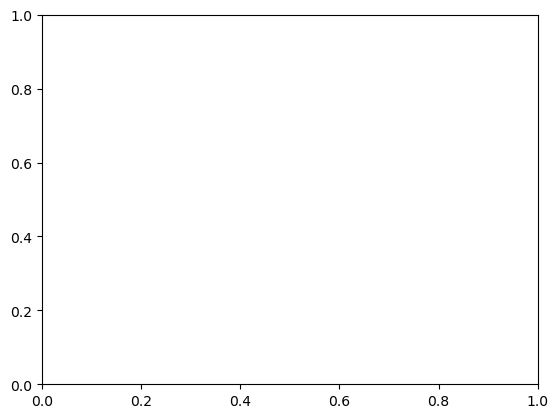

In [144]:
color_t=['red','blue','green']
for i in range(len(bond_dims)):
  plt.plot(time_values, sigma_x_1[i], label=f'$\chi$ = {bond_dims[i]}',color=color_t[i])
plt.legend()
plt.xlabel('Time')
plt.ylabel(r'Expectation value of $\sigma_x^1$ vs time')
plt.savefig('Expectation value ofsigma_x1 vs time.png')
plt.show()
for i in range(len(bond_dims)):
  plt.plot(time_values, sigma_x_L2[i], label=f'\chi = {bond_dims[i]}',color=color_t[i])
plt.legend()
plt.xlabel('Time')
plt.ylabel(r'Expectation value of $\sigma_x^{L/2}$ vs time')
plt.savefig('Expectation value of sigma_xL2 vs time.png')
plt.show()
for i in range(len(bond_dims)):
  plt.plot(time_values, sigma_z_1[i], label=f'\chi = {bond_dims[i]}',color=color_t[i])
plt.legend()
plt.xlabel('Time')
plt.ylabel(r'Expectation value of $\sigma_z^1$')
plt.savefig('Expectation value of sigma_x1 vs time.png')
plt.show()
for i in range(len(bond_dims)):
  plt.plot(time_values, sigma_x_1[i], label=f'\chi = {bond_dims[i]}',color=color_t[i])
plt.legend()
plt.xlabel('Time')
plt.ylabel(r'Expectation value of $\sigma_z^{L/2}$')
plt.savefig('Expectation value of sigma_zL2 vs time.png')
plt.show()
for i in range(len(bond_dims)):
  plt.plot(time_values, entanglement_entropy_values[i], label=f'\chi = {bond_dims[i]}',color=color_t[i])
plt.legend()
plt.xlabel('Time')
plt.ylabel(r'Entanglement entropy')
plt.savefig('entaglement-entropy.png')
plt.show()

In [71]:
def exp_val_Cz(r, canonical_tracker):
    Z = np.array([[1, 0], [0, -1]])
    U = canonical_tracker[r][0]
    S = np.diag(canonical_tracker[r][1])
    Ssq = np.einsum('ij,kj->ik', S.conj(), S)
    ZU = np.einsum('ij,kjm->kim', Z, U)
    ZUS = np.einsum('kim,nm->kin', ZU, Ssq)
    UhZUS = np.einsum('aib,kin->akbn', U.conj(), ZUS)
    return np.einsum('aabb', UhZUS)/(np.sum(Ssq))
def exp_val_Cx(r, canonical_tracker):
    X = np.array([[0, 1], [1, 0]])
    U = canonical_tracker[r][0]
    S = np.diag(canonical_tracker[r][1])
    Ssq = np.einsum('ij,kj->ik', S.conj(), S)
    XU = np.einsum('ij,kjm->kim', X, U)
    XUS = np.einsum('kim,nm->kin', XU, Ssq)
    UhXUS = np.einsum('aib,kin->akbn', U.conj(), XUS)
    return np.einsum('aabb', UhXUS)/(np.sum(Ssq))

In [ ]:
observables_1 = []
observables_2 = []
observables_3 = []
for i in range(len(canonical_trackers)):
    observable = exp_val_Cz(L//2, canonical_trackers[i])
    observables_1.append(observable)
    observable = exp_val_Cz(L//2, canonical_trackers_1[i])
    observables_2.append(observable)
    observable = exp_val_Cz(L//2, canonical_trackers_3[i])
    observables_3.append(observable)
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, observables_3, color='xkcd:blue', label=r'$\chi=8$')  
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, observables_1, color='xkcd:green', label=r'$\chi=16$')
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, observables_2, color='xkcd:bright red', label=r'$\chi=32$')
         
plt.xlabel('t')
plt.ylabel(r'$\langle\sigma^z_{L/2}\rangle(t)$')
plt.title(r'Time evolution of $\langle\sigma^z_{L/2}\rangle$(t)')
plt.legend()
plt.savefig('time_evolution_sigmazLover2_64.png')
plt.show()

In [ ]:
observables_1 = []
observables_2 = []
observables_3 = []
for i in range(len(canonical_trackers)):
    observable = exp_val_Cx(L//2, canonical_trackers[i])
    observables_1.append(observable)
    observable = exp_val_Cx(L//2, canonical_trackers_2[i])
    observables_2.append(observable)
    observable = exp_val_Cx(L//2, canonical_trackers_3[i])
    observables_3.append(observable)
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, observables_3, color='xkcd:royal blue', label=r'$\chi=8$')  
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, observables_1, color='xkcd:green', label=r'$\chi=16$')
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, observables_2, color='xkcd:bright red', label=r'$\chi=32$')
plt.xlabel('t')
plt.ylabel(r'$\langle\sigma^x_{L/2}\rangle(t)$')
plt.title(r'Time evolution of $\langle\sigma^x_{L/2}\rangle$(t)')
plt.legend()
plt.savefig('time_evolution_sigmaxLover2_64.png')
plt.show()

In [92]:
def entang_entropy(l, canonical_tracker):
    s = canonical_tracker[l][1]
    lambdas = s**2
    lambdas = lambdas/np.sum(lambdas)
    S = -np.sum(lambdas * np.log(lambdas))
    return S

In [ ]:
entropies_1 = []
entropies_2 = []
entropies_3 = []
for i in tqdm(range(len(canonical_trackers)), desc="Computing Entropies"):
    entropy = entang_entropy(L//2, canonical_trackers[i])
    entropies_1.append(entropy)
    entropy = entang_entropy(L//2, canonical_trackers_2[i])
    entropies_2.append(entropy)
    entropy = entang_entropy(L//2, canonical_trackers_3[i])
    entropies_3.append(entropy)
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, entropies_3, color='xkcd:royal blue', label=r'$\chi=8$')    
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, entropies_1, color='xkcd:green', label=r'$\chi=16$')
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, entropies_2, color='xkcd:bright red', label=r'$\chi=32$')
plt.title('entanglement entropy vs time')
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$S_{L/2}(t)$')
plt.savefig('entaglement_entropy_vs_timesL64.png')

In [ ]:
evolved_ket_3, canonical_trackers_3 = evolve_time(t, J, hx, hz, ket, 64, 1000)
evolved_ket_4, canonical_trackers_4 = evolve_time(t, J, hx, hz, ket, 128, 1000)

In [ ]:
observables_1 = []
observables_2 = []
for i in tqdm(range(len(canonical_trackers)), desc="Computing observables"):
    observable = expectation_value_Cz(L//2, canonical_trackers_3[i])
    observables_1.append(observable)
    observable = expectation_value_Cz(L//2, canonical_trackers_4[i])
    observables_2.append(observable)
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_1, color='xkcd:bright red', label=r'$\chi=4$')
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_2, color='xkcd:green', label=r'$\chi=8$')
plt.xlabel('t')
plt.ylabel(r'$\langle\sigma^z_{L/2}\rangle(t)$')
plt.title(r'Time evolution of $\langle\sigma^z_{L/2}\rangle$(t)')
plt.legend()
plt.savefig('time evolution sigmazLover2L14.png')
plt.show()

In [ ]:
observables_1 = []
observables_2 = []
for i in tqdm(range(len(canonical_trackers)), desc="Computing observables"):
    observable = expectation_value_Cx(L//2, canonical_trackers_3[i])
    observables_1.append(observable)
    observable = expectation_value_Cx(L//2, canonical_trackers_4[i])
    observables_2.append(observable)
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_1, color='xkcd:bright red', label=r'$\chi=4$')
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_2, color='xkcd:green', label=r'$\chi=8$')
plt.xlabel('t')
plt.ylabel(r'$\langle\sigma^x_{L/2}\rangle(t)$')
plt.title(r'Time evolution of $\langle\sigma^x_{L/2}\rangle$(t)')
plt.legend()
plt.savefig('timeevolution_sigmaxLover2L14.png')
plt.show()

In [ ]:
L = 16
ket = neel_state(L)
evolved_ket_neel, canonical_trackers_neel_1 = evolve_time(t, J, hx, hz, ket, chi, int(t/dt))
evolved_ket2_neel, canonical_trackers_neel_2 = evolve_time(t, J, hx, hz, ket, 32, int(t/dt))
evolved_ket3_neel, canonical_trackers_neel_3 = evolve_time(t, J, hx, hz, ket, 64, int(t/dt))

In [ ]:
entropies_1 = []
entropies_2 = []
entropies_3 = []
for i in tqdm(range(len(canonical_trackers_neel)), desc="Computing Entropies"):
    entropy = entanglement_entropy(L//2, canonical_trackers_neel_1[i])
    entropies_1.append(entropy) 
    entropy = entanglement_entropy(L//2, canonical_trackers_neel_2[i])
    entropies_2.append(entropy)
    entropy = entanglement_entropy(L//2, canonical_trackers_neel_3[i])
    entropies_3.append(entropy)
plt.plot(np.arange(0, len(canonical_trackers_neel), 1)*dt, entropies_1, color='xkcd:royal blue', label=r'$\chi=16$')
plt.plot(np.arange(0, len(canonical_trackers_neel), 1)*dt, entropies_2, color='xkcd:bright red', label=r'$\chi=32$')
plt.plot(np.arange(0, len(canonical_trackers_neel), 1)*dt, entropies_3, color='xkcd:green', label=r'$\chi=64$')
plt.title('entanglement entropy vs time')
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$S_{L/2}(t)$')
plt.savefig('entaglement_entropy_vs_timeL30.png')

4.3

In [99]:
def evolve(psi, hx_values, hz_values, J, dt):
  psi_copy = copy.deepcopy(psi)
  L = len(psi)
  for i in range(L):
    hx = hx_valoes[i]
    hz = hz_values[i]
    psi_copy = field(psi_copy, hx, hz, dt, i)
  for i in range(1, L - 1, 2):
    psi_copy = site(psi_copy, J, dt, i)
  for i in range(0, L - 1, 2):
    psi_copy = site(psi_copy, J, dt, i)
  return psi_copy

In [147]:
sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
dt = 0.1
time_values = dt * np.array(range(101))
L = 32
W = 3
sigma_x_1 = np.zeros_like(time_values, dtype=np.complex_)
sigma_x_L2 = np.zeros_like(time_values, dtype=np.complex_)
sigma_z_1 = np.zeros_like(time_values, dtype=np.complex_)
sigma_z_L2 = np.zeros_like(time_values, dtype=np.complex_)
entanglement_entropy_values = np.zeros_like(time_values, dtype=np.complex_)
iterations = 10
for i in range(iterations):
    hx_values = np.random.uniform(-W, W, L)
    hz_values = np.random.uniform(-W, W, L)
    psi = psi_initial_mps(L)
    x_1 = []
    x_L2 = []
    z_1 = []
    z_L2 = []
    list_entaglement_entropy = []
    for i in time_values:
        psi = time_evolve(psi, hx_values, hz_values, J, dt * 1j)
        psi = canonicalize(psi, 16, 0)[1]
        psi_L2 = canonicalize(psi_L2, 16, int(L/2))[1]
        x_1.append(observable(psi, sigma_x, 0))
        x_L2.append(observable(psi_L2, sigma_x, int(L/2)))
        z_1.append(observable(psi, sigma_z, 0))
        z_L2.append(observable(psi_L2, sigma_z, int(L/2)))
        list_entaglement_entropy.append(entanglement_entropy(psi, bond_dim, int(L/2)))
    sigma_x_1 += np.array(x_1) / iterations
    sigma_x_L2 += np.array(x_L2) / iterations
    sigma_z_1 += np.array(z_1) / iterations
    sigma_z_L2 += np.array(z_L2) / iterations
    entanglement_entropy_values += np.array(list_entaglement_entropy) / iterations

LinAlgError: Last 2 dimensions of the array must be square

ValueError: x and y must have same first dimension, but have shapes (101,) and (3, 11)

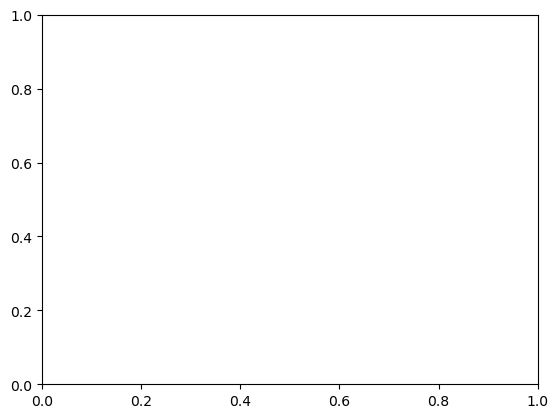

In [142]:
plt.plot(time_values, sigma_x_1,color='indigo')
plt.xlabel('Time')
plt.ylabel(r'Expectation value of $\sigma_x^1$')
plt.savefig('expectation-value_x_143.png')
plt.show()

plt.plot(time_values, sigma_x_L2,color='red')
plt.xlabel('Time')
plt.ylabel(r'Expectation value of $\sigma_x^{L/2}$')
plt.savefig('expectation-value_x_L2_143.png')
plt.show()

plt.plot(time_values, sigma_z_1,color='pink')
plt.xlabel('Time')
plt.ylabel(r'Expectation Value of $\sigma_z^1$')
plt.savefig('expectation-value_z_143.png')
plt.show()

plt.plot(time_values, sigma_z_L2,color='blue')
plt.xlabel('Time')
plt.ylabel(r'Expectation Value of $\sigma_z^{L/2}$')
plt.savefig('expectation-value_z_L2_43.png')
plt.show()

plt.plot(time_values, entanglement_entropy_values,color='green')
plt.xlabel('Time')
plt.ylabel(r'Entanglement Entropy')
plt.savefig('entaglement_entropy.png')
plt.show()
